# Spotify Podcast Dataset - Publisher



In [1]:
import pandas as pd
import altair as alt
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../../podcasts-no-audio-13GB-selected/metadata_with_episode_dates_and_category.tsv',sep='\t')
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d').reset_index(drop=True)
df = df[~df['release_date'].isna()]
df = df[~df['category'].isna()]

# Dataset is constrained to start_date and end_date
#start_date = pd.to_datetime("2019-01-01")
#end_date = pd.to_datetime("2020-03-01")

# Filter the DataFrame to include only rows between start_date and end_date
#df = df[(df.release_date >= start_date) & (df.release_date <= end_date)]

In [3]:
df.shape

(90873, 18)

In [4]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

# Publisher Specific Insights

In [5]:
df['publisher'].unique()

array(['Katie Houle', 'Morning Cup Of Murder', 'Inside the 18 GK Media',
       ..., 'High Schooler ', 'Zach Valen', 'Chelsea Batalla'],
      dtype=object)

## Publisher Summary Stats

In [6]:
df_ss = df[df['publisher']=='Spotify Studios']

In [7]:
df_ss.shape

(1156, 18)

In [8]:
df_pub_barchart_values = np.array([
    # number of shows
    df_ss['show_filename_prefix'].unique().shape[0],
    # number of total episodes
    df_ss['episode_filename_prefix'].unique().shape[0],
    # average number of episodes per show
    df_ss.groupby('show_filename_prefix').size().mean()
])
df_pub_barchart_values

array([  42.        , 1156.        ,   27.52380952])

In [9]:
df_pub_barchart_categories = np.array(['number_of_shows', 'number_of_episodes', 'mean_number_of_episodes_per_show'])

In [10]:
cols = ['Category','Values']
df_pub_barchart = pd.DataFrame(np.array([df_pub_barchart_categories, df_pub_barchart_values]).T, columns=cols)
df_pub_barchart

,Category,Values
0,number_of_shows,42.0
1,number_of_episodes,1156.0
2,mean_number_of_episodes_per_show,27.523809523809526


In [11]:
df_pub_barchart.dtypes

Category    object
Values      object
dtype: object

In [12]:
# bar chart of number of shows, number of episodes, number of episodes per show
bar_chart = alt.Chart(df_pub_barchart).mark_bar().encode(
    x='Values:Q',  # Quantitative scale for the y-axis
    y=alt.X('Category:N'),
    tooltip=['Values']
).configure_scale(
    bandPaddingInner=0.2,
)

bar_chart = bar_chart.properties(width=300, height=200)
bar_chart.save('publisher_summary_bar_chart.json')
bar_chart

alt.Chart(...)

## Publisher Timeseries Stats

In [13]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

In [14]:
df.dtypes

show_uri                           object
show_name                          object
show_description                   object
publisher                          object
language                           object
rss_link                           object
episode_uri                        object
episode_name                       object
episode_description                object
duration                          float64
show_filename_prefix               object
episode_filename_prefix            object
release_date               datetime64[ns]
first_dir                           int64
second_dir                         object
category                           object
mean_show_duration                float64
top_5                              object
dtype: object

In [15]:
df['release_date']

0        2019-12-18
1        2020-01-30
2        2019-01-18
3        2019-03-01
5        2019-10-16
            ...    
105355   2019-03-29
105356   2019-05-04
105357   2019-01-08
105358   2019-06-25
105359   2019-10-27
Name: release_date, Length: 90873, dtype: datetime64[ns]

In [16]:
df_ss = df[df['publisher']=='Spotify Studios']

In [17]:

# First group by show name AND aggregate time by month AND THEN get the counts which will give you the episodes per month by show for every month.
# then take the average over all months to get the average episodes per month by show. 
monthly_counts = df_ss[['show_name','release_date']].groupby(['show_name',df_ss.release_date.dt.to_period("M")]).agg('count') \
    .groupby('show_name').mean().sort_values(by='release_date',ascending=False)
monthly_counts = monthly_counts.reset_index()

# Reset the index to have 'Date' as a column again
monthly_counts['episodes_per_month'] = monthly_counts['release_date']
monthly_counts.drop('release_date',axis=1,inplace=True)
# Display the resulting DataFrame
monthly_counts.head()


,show_name,episodes_per_month
0,The Hottest Take,15.000000
1,Spotify x IPG Mediabrands,12.000000
2,21 Days with mxmtoon,8.000000
3,Jemele Hill is Unbothered,7.545455
4,Identify,7.000000


In [18]:
monthly_counts.head()

,show_name,episodes_per_month
0,The Hottest Take,15.000000
1,Spotify x IPG Mediabrands,12.000000
2,21 Days with mxmtoon,8.000000
3,Jemele Hill is Unbothered,7.545455
4,Identify,7.000000


In [19]:
# bar chart of number of shows, number of episodes, number of episodes per show
bar_chart2 = alt.Chart(monthly_counts).mark_bar().encode(
    x=alt.X('episodes_per_month:Q'),  # Quantitative scale for the y-axis
    y=alt.Y('show_name:N').sort('-x')
).configure_scale(
    bandPaddingInner=0.2,
)

bar_chart2 = bar_chart2.properties(width=300, height=500)
bar_chart2.save('publisher_episodes_by_month_bar_chart.json')
bar_chart2


alt.Chart(...)

# General Insights for Publishers

## Find Shows by Publisher

In [20]:
df_pub2show = df.groupby(['publisher','show_name']).size().sort_values(ascending=False).reset_index().groupby('publisher').size().sort_values(ascending=False)
df_pub2show = pd.DataFrame(df_pub2show, columns=['Number of Shows']).reset_index()
# Calculate circle sizes based on 'Value'
#df_pub2show['CircleSize'] = np.sqrt(df_pub2show['Number of Shows'])
df_pub2show['Number of Shows Jitter'] = df_pub2show['Number of Shows'] + np.abs(np.random.normal(0,1,(len(df_pub2show),)))

## Find Episodes by Publisher

In [21]:
df_pub2episode = df.groupby('publisher').size().sort_values(ascending=False)
df_pub2episode = pd.DataFrame(df_pub2episode, columns=['Number of Episodes']).reset_index()
# Calculate circle sizes based on 'Value'
df_pub2episode['CircleSize'] = np.sqrt(df_pub2episode['Number of Episodes'])
df_pub2episode['Number of Episodes Jitter'] = df_pub2episode['Number of Episodes'] + np.abs(np.random.normal(0,1,(len(df_pub2show),)))
df_pub2episode.shape

(15129, 4)

In [22]:
df_pub = df_pub2episode.merge(df_pub2show,on='publisher',how='left')

## Plot of All Publishers

In [23]:
import altair as alt
import pandas as pd
import numpy as np

# Create a scatter plot with circles to represent the categorical table
circle_table = alt.Chart(df_pub.sample(5000)).mark_circle().encode(
    x=alt.X('publisher:O', axis=alt.Axis(labels=False, title='')),
    y=alt.Y('Number of Episodes Jitter:Q', scale=alt.Scale(type='log'), axis=alt.Axis(labels=False, title='')),
    size=alt.Size('CircleSize:Q', scale=alt.Scale(range=[5, 2000]), legend=None),  # Adjust size range as needed
    #color=alt.Color('publisher:N', legend=None),
    color=alt.Color(scale=alt.Scale(scheme='blueorange-8')),
    tooltip=['publisher:N', 'Number of Episodes:Q','Number of Shows:Q']  # Add a tooltip with 'Category' and 'Value'
).properties(
    width=600,
    height=600,
    title='Podcast Publishers (Hover Over)'
).configure_title(
    fontSize=16,
    anchor='middle'
).configure_axis(
    grid=False  # Remove gridlines
).configure_axisY(
    ticks=False
)

circle_table

alt.Chart(...)

In [24]:
df_ss.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

## Single Publisher Word Cloud

df_ss.cateory

In [25]:
df_filtered = df[~df['category'].isna()]
df_filtered.shape

(90873, 18)

In [26]:
df_ss = df_filtered[df_filtered['publisher']=='Spotify Studios']

In [27]:
category_raw_counts = []
for i,val in df_ss['category'].items():
   category_raw_counts.extend(val.split(','))
len(category_raw_counts)

2236

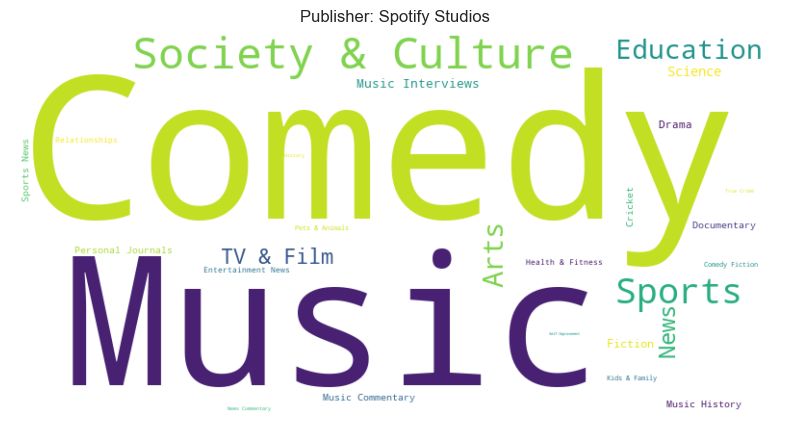

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

category_counts = Counter(category_raw_counts)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))
values, frequencies = zip(*sorted_counts.items())

# Generate the word cloud with the specified font
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Publisher: Spotify Studios')
plt.show()

In [29]:
wc.to_file(filename='publisher_word_cloud.png')

In [30]:
category_list = [k for k,v in sorted_counts.items()]
frequency_list = [v for k,v in sorted_counts.items()]
cat_df = pd.DataFrame(np.array([category_list, frequency_list]).T,columns=['Categories','Frequency'])


In [54]:
cat_df['Frequency'] = pd.to_numeric(cat_df['Frequency'], errors='coerce').astype('Int64')

In [55]:
# bar chart

bar_chart3 = alt.Chart(cat_df).mark_bar().encode(
    x=alt.X('Frequency:Q'),  # Quantitative scale for the y-axis
    y=alt.Y('Categories:N').sort('-x')
).configure_scale(
    bandPaddingInner=0.2,
).properties(
    width=1000,
    height=600,
    title='Podcast Show Categories'
).configure_axisY(
    titleAlign='left',  # Align the title to the left
    titleAnchor='end',  # Set the title anchor to the end
    labelAlign='right',  # Align the labels to the right
)

#bar_chart2 = bar_chart2.properties(width=300, height=500)
bar_chart3.save('publisher_categories_bar_chart.json')
bar_chart3

alt.Chart(...)

## Single Publisher Take 2

Get number of shows per category...

In [32]:
df_filtered = df[~df['category'].isna()]
df_ss = df_filtered[df_filtered['publisher']=='Spotify Studios']

In [33]:
# Function to split the string in category and create a new DataFrame
def process_row(row):
    split_values = row['category'].split(',')
    new_df = pd.DataFrame({'category': split_values, 'show_uri': row['show_uri']})
    return new_df

result_df = pd.concat(df_ss.apply(process_row, axis=1).tolist(), ignore_index=True)
result_df

,category,show_uri
0,Music,spotify:show:2b025hq3gJ17tQdxS3aV43
1,Education,spotify:show:2b025hq3gJ17tQdxS3aV43
2,Arts,spotify:show:2b025hq3gJ17tQdxS3aV43
3,Music,spotify:show:2b025hq3gJ17tQdxS3aV43
4,Education,spotify:show:2b025hq3gJ17tQdxS3aV43
...,...,...
2231,Comedy,spotify:show:1SXD1U55jqbK9HHoPvdbsw
2232,Society & Culture,spotify:show:1SXD1U55jqbK9HHoPvdbsw
2233,Comedy,spotify:show:5JFugv0GD68SZC0Cuh1wXi
2234,Music,spotify:show:2YissX4xRk9cU2r10620ol


<Axes: ylabel='category'>

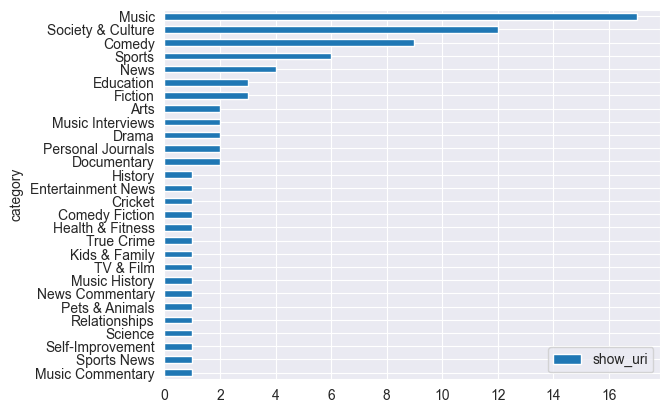

In [34]:
result_df.groupby('category').nunique().sort_values(by='show_uri',ascending=True).plot.barh()

In [35]:
df_ss_jhiu = df_ss[df_ss.show_uri=='spotify:show:1SXD1U55jqbK9HHoPvdbsw'].sort_values(by='release_date')[['show_uri','show_name','release_date','duration','category','episode_uri','episode_name']]

In [36]:
df_ss_jhiu['episode_number'] = df_ss_jhiu.reset_index().index

In [37]:
df_ss_jhiu

,show_uri,show_name,release_date,duration,category,episode_uri,episode_name,episode_number
49162,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2019-04-08,1.672267,"News,Comedy,Society & Culture",spotify:episode:3bIJRAHqgxT8d0T0hvPeAs,Jemele Hill is Unbothered Premieres Monday Apr...,0
51252,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2019-04-18,61.233200,"News,Comedy,Society & Culture",spotify:episode:3khFc57fzFzVWduyi5n3Cs,Ep 02: Up Negro Creek (feat. Killer Mike),1
84141,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2019-04-22,67.761200,"News,Comedy,Society & Culture",spotify:episode:6D4Xsf7AjPeCVOwkkmJZbZ,Ep 03: Cheers and Boos (feat. T.I.),2
98136,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2019-04-25,72.985250,"News,Comedy,Society & Culture",spotify:episode:7FYqIZFMQN1DSL9iKkBosi,Ep 04: Still Not A Role Model (feat. Charles B...,3
13961,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2019-05-02,55.640817,"News,Comedy,Society & Culture",spotify:episode:11ruVGUSapReBiCzVrftYr,"Ep 06: Uncomfortable, But Not Offended (feat. ...",4
...,...,...,...,...,...,...,...,...
78460,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2020-02-13,54.207133,"News,Comedy,Society & Culture",spotify:episode:5mWrWQet5ZV2f7Mo3gK92Y,Ep 80: Two Black Women Did This Podcast (feat....,78
72805,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2020-02-17,74.832983,"News,Comedy,Society & Culture",spotify:episode:5MjWIXQui5jEwupVysBN4E,Ep 81: A Conversation in Truth (feat. Ed Gordon),79
8424,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2020-02-20,68.157383,"News,Comedy,Society & Culture",spotify:episode:0cWIxRutmLe2NygicUWigp,Ep 82: What Doesn’t Kill You Makes You Doper (...,80
80794,spotify:show:1SXD1U55jqbK9HHoPvdbsw,Jemele Hill is Unbothered,2020-02-24,86.756133,"News,Comedy,Society & Culture",spotify:episode:5xHlFKQO9nIb73ilab2spU,Ep 83: Playing With Our Emotions (feat Benjami...,81


## Create episode number for each show

In [38]:
counter = 0
size_of_show = []
df_new = pd.DataFrame()
# iterate through all shows and then concate them into another 
# data frame.
# a is the show
# b is a dataframe with the resulting shows.
for a,b in df.groupby('show_uri'):
    counter += 1
    # sort values by release date before creating the episode number
    # also filtered to only use columns that are relavant.
    b = b.sort_values(by='release_date')[['show_uri','show_name','release_date','duration','category','episode_uri','episode_name','publisher']]
    # create episode number based on release date.
    # this has issues when the author uploads
    # many episodes at a time.  there appears to be 
    # a need to clean data like that at some point.
    b['episode_number'] = b.reset_index().index
    df_new = pd.concat([df_new,b])

In [39]:
df_new.columns

Index(['show_uri', 'show_name', 'release_date', 'duration', 'category',
       'episode_uri', 'episode_name', 'publisher', 'episode_number'],
      dtype='object')

In [40]:
df_new.shape

(90873, 9)

In [41]:
df_new.category.isna().sum()

0

In [42]:
# Function to split the string in category and create a new DataFrame
def process_row(row):
    split_values = row['category'].split(',')
    new_df = pd.DataFrame({'category': split_values, 'show_uri': row['show_uri'], 'show_name':row['show_name'],'release_date': row['release_date'],'duration':row['duration'],'episode_uri':row['episode_uri'],'episode_name':row['episode_name'],'episode_number':row['episode_number'],'publisher':row['publisher']})
    return new_df

result_df = pd.concat(df_new.apply(process_row, axis=1).tolist(), ignore_index=True)
result_df

,category,show_uri,show_name,release_date,duration,episode_uri,episode_name,episode_number,publisher
0,Society & Culture,spotify:show:002B8PbILr169CdsS9ySTH,The Mother Bakker Podcast,2019-11-17,57.177200,spotify:episode:399kdfMnjw0KYANZU7CQJ0,"Ep #1 | Mim, Mems & Mates",0,Mim Bakker
1,Leisure,spotify:show:005ZAjJK1wlD4E2YxeibBb,AK UNFILTERED,2020-01-03,82.179683,spotify:episode:49wcMBeJfaaL6KFFdsWvac,EPISODE 14: Stephanie Soo vs. Nikocado Avocado...,0,AK
2,Comedy,spotify:show:007ISDom3HctggVaUjno6B,What About Everything,2019-04-15,50.919183,spotify:episode:0JOymLFsRdeBVZbEA72ayj,Episode One - Pilot,0,Brendan Phillips
3,Business,spotify:show:00BUDdSn801kmcWw50Us8S,Planetary Potential,2019-10-27,32.422317,spotify:episode:1WosITIkpJemzZaPh8zAVb,Ep. 12 - Starting a business by solving your o...,0,Andrew P. Rowan
4,Entrepreneurship,spotify:show:00BUDdSn801kmcWw50Us8S,Planetary Potential,2019-10-27,32.422317,spotify:episode:1WosITIkpJemzZaPh8zAVb,Ep. 12 - Starting a business by solving your o...,0,Andrew P. Rowan
...,...,...,...,...,...,...,...,...,...
136570,Health & Fitness,spotify:show:7zzkvuWptdxJnN3ezTrKNl,Stripped by SIA,2020-01-18,52.715883,spotify:episode:4lEZbExYs55wrpDWz2uu2x,#19 - Pushing Boundaries and Going Deeper into...,20,STEPHANIE SIA
136571,Sexuality,spotify:show:7zzkvuWptdxJnN3ezTrKNl,Stripped by SIA,2020-01-18,52.715883,spotify:episode:4lEZbExYs55wrpDWz2uu2x,#19 - Pushing Boundaries and Going Deeper into...,20,STEPHANIE SIA
136572,Health & Fitness,spotify:show:7zzkvuWptdxJnN3ezTrKNl,Stripped by SIA,2020-01-26,70.076667,spotify:episode:2HkvQhUuwLh1rWuH2tL13k,"#20 - I've Always Been Known as ""The Girl with...",21,STEPHANIE SIA
136573,Sexuality,spotify:show:7zzkvuWptdxJnN3ezTrKNl,Stripped by SIA,2020-01-26,70.076667,spotify:episode:2HkvQhUuwLh1rWuH2tL13k,"#20 - I've Always Been Known as ""The Girl with...",21,STEPHANIE SIA


In [43]:
result_df['release_date']

0        2019-11-17
1        2020-01-03
2        2019-04-15
3        2019-10-27
4        2019-10-27
            ...    
136570   2020-01-18
136571   2020-01-18
136572   2020-01-26
136573   2020-01-26
136574   2019-01-02
Name: release_date, Length: 136575, dtype: datetime64[ns]

In [44]:
result_df[result_df['show_uri']=='spotify:show:7zzkvuWptdxJnN3ezTrKNl'].shape

(44, 9)

In [45]:
df[df['show_uri']=='spotify:show:7zzkvuWptdxJnN3ezTrKNl'].shape

(22, 18)

In [46]:
df[df['show_uri']=='spotify:show:7zzkvuWptdxJnN3ezTrKNl'].category.unique()

array(['Health & Fitness,Sexuality'], dtype=object)

In [47]:
json_data = result_df.to_json(date_format='iso',orient='records')

In [48]:
import json
# Parse JSON string into a Python object (list of dictionaries)
obj = json.loads(json_data)

# Specify the file path where you want to save the JSON data
file_path = 'publisher_raw_data.json'

# Save the JSON data to the file
with open(file_path, 'w') as json_file:
    json.dump(obj, json_file)

print(f'The JSON data has been saved to {file_path}')

The JSON data has been saved to publisher_raw_data.json
